##Смирнов Иван


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf

from sklearn.decomposition import PCA
from sklearn import linear_model

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

### Получим цены закрытия акций

In [2]:
def get_One_Asset(company, start_day):
  df = pd.DataFrame()
  returns = yf.Ticker(company)
  data = returns.history(period="1y", start=start_day)
  df.index = data.index
  df[company] = data.Close

  return df

In [3]:
start_day = '2021-01-01'
assetList = ['BA', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BIIB', 'BIO', 'BK']

In [4]:
data = pd.DataFrame()

for company in assetList:
    asset = get_One_Asset(company, start_day)
    data = pd.concat([data, asset], axis = 1)

Выполним нормировку данных

In [5]:
dataNorm = (data - data.mean() ) / data.std()

In [6]:
dataNorm.head()

,BA,BAC,BAX,BBY,BDX,BEN,BIIB,BIO,BK
Date,,,,,,,,,
2021-01-04 00:00:00-05:00,0.163286,-1.700585,0.620739,0.093885,-0.424122,-1.685637,-0.412833,-0.005524,-1.451215
2021-01-05 00:00:00-05:00,0.417693,-1.656165,0.696998,0.123629,-0.395069,-1.703613,-0.337120,0.070326,-1.372702
2021-01-06 00:00:00-05:00,0.400561,-1.291145,0.677586,0.409987,-0.165293,-1.329132,-0.307188,0.310360,-0.896610
2021-01-07 00:00:00-05:00,0.448530,-1.154022,0.715716,0.514966,-0.177618,-1.341116,-0.247982,0.455047,-0.851506
2021-01-08 00:00:00-05:00,0.368296,-1.217757,0.730274,0.506800,-0.040277,-1.404027,-0.201763,0.388775,-0.931690


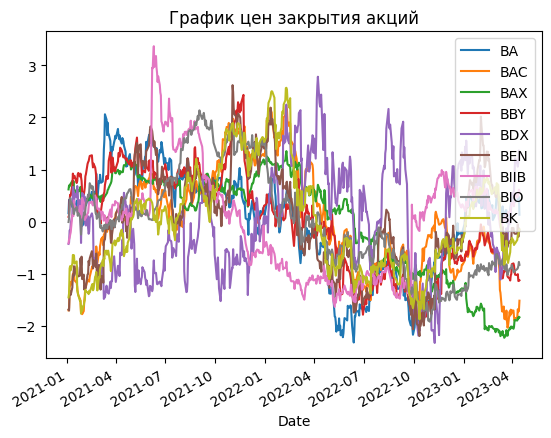

In [7]:
dataNorm.plot(title='График цен закрытия акций');

### Проведём анализ метода главных компонент нормированных цен

In [8]:
pca = PCA(svd_solver='full')
pca.fit(dataNorm)
print('Explained variance by factors:\n', pca.explained_variance_.round(1))

Explained variance by factors:
 [4.8 1.7 1.  0.7 0.3 0.2 0.1 0.1 0. ]


Вычислим главные факторы

In [9]:
pca_factors = pd.DataFrame(pca.transform(dataNorm), 
                           columns=['pca.f{}'.format(i+1) for i in range(pca.n_components_)], 
                           index=dataNorm.index)
pca_factors.head()

,pca.f1,pca.f2,pca.f3,pca.f4,pca.f5,pca.f6,pca.f7,pca.f8,pca.f9
Date,,,,,,,,,
2021-01-04 00:00:00-05:00,1.574228,-0.809211,-2.002507,-0.863722,0.380315,-0.459096,-0.399619,-0.243501,0.383485
2021-01-05 00:00:00-05:00,1.366576,-0.867210,-2.004708,-0.967786,0.429912,-0.415553,-0.555025,-0.321931,0.368068
2021-01-06 00:00:00-05:00,0.723614,-0.537035,-1.682814,-0.941354,0.292529,-0.460359,-0.497936,-0.115461,0.392959
2021-01-07 00:00:00-05:00,0.520343,-0.537565,-1.740281,-0.934533,0.229612,-0.454103,-0.552180,-0.050503,0.325732
2021-01-08 00:00:00-05:00,0.650023,-0.506397,-1.759238,-1.059006,0.172836,-0.375506,-0.504315,-0.022758,0.347026


### Посмотрим график важности каждой главной компоненты

<BarContainer object of 9 artists>

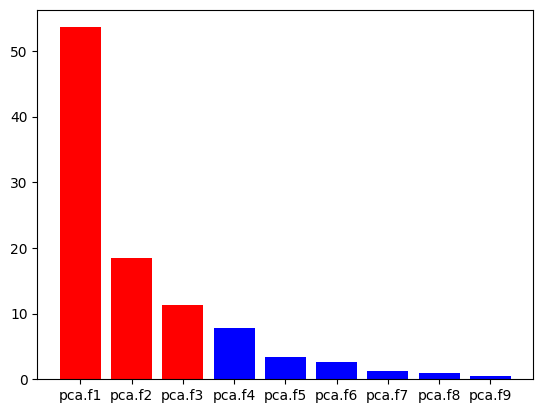

In [77]:
plt.bar(['pca.f{}'.format(i+1) for i in range(pca.n_components_)], height=pca.explained_variance_ratio_ * 100,
        color=['red' for i in range(3)] + ['blue' for i in range(pca.n_components_ - 3)])

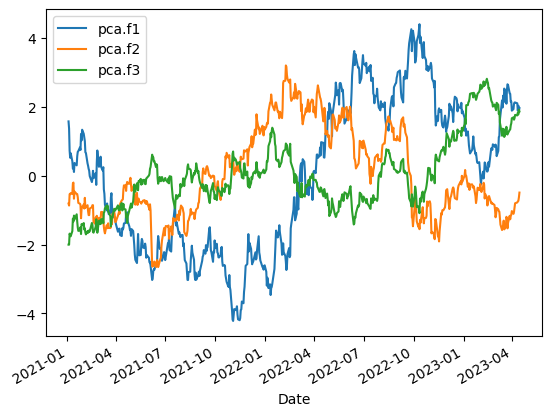

In [10]:
pca_factors[['pca.f1', 'pca.f2','pca.f3']].plot();

### Получим 3 главных копоненты и три соответствующих вектора факторных нагрузок

Получим факторные нагрузки

In [11]:
stocks = pd.DataFrame({'stocks': assetList})
pca_loadings = pd.DataFrame(pca.components_)
pca_loadings = pca_loadings.transpose()
pca_loadings.columns = ['pca.l{}'.format(i+1) for i in range(pca.n_components_)]
pca_loadings = stocks.join(pca_loadings)
pca_loadings

,stocks,pca.l1,pca.l2,pca.l3,pca.l4,pca.l5,pca.l6,pca.l7,pca.l8,pca.l9
0,BA,-0.358802,-0.308267,0.108279,-0.354513,0.531758,-0.009902,-0.453376,-0.328977,-0.205399
1,BAC,-0.376185,0.291362,0.040086,0.385083,0.015379,0.453278,-0.069158,0.219287,-0.604260
2,BAX,-0.312498,0.214653,-0.621068,-0.041345,0.052328,0.380019,0.179396,-0.411037,0.347200
3,BBY,-0.406112,-0.114110,-0.231732,-0.271923,0.227961,-0.147341,0.221845,0.741348,0.148062
4,BDX,0.057637,0.553655,0.254108,-0.740437,-0.183829,0.192435,0.008196,0.031673,-0.073700
5,BEN,-0.380816,0.018499,0.465114,0.064507,0.090977,-0.207559,0.697457,-0.309174,-0.027444
6,BIIB,-0.187630,-0.618467,0.170590,-0.166333,-0.540669,0.474849,0.042606,0.027911,0.071608
7,BIO,-0.388828,0.069884,-0.274360,-0.062107,-0.567135,-0.567982,-0.193018,-0.141252,-0.251685
8,BK,-0.363908,0.258306,0.402453,0.257774,-0.079109,-0.010985,-0.427416,0.088411,0.612824


Посмотрим на первые три факторные нагрузки

PCA loadings: 
   stocks    pca.l1    pca.l2    pca.l3
0     BA -0.358802 -0.308267  0.108279
1    BAC -0.376185  0.291362  0.040086
2    BAX -0.312498  0.214653 -0.621068
3    BBY -0.406112 -0.114110 -0.231732
4    BDX  0.057637  0.553655  0.254108
5    BEN -0.380816  0.018499  0.465114
6   BIIB -0.187630 -0.618467  0.170590
7    BIO -0.388828  0.069884 -0.274360
8     BK -0.363908  0.258306  0.402453


<Axes: xlabel='stocks'>

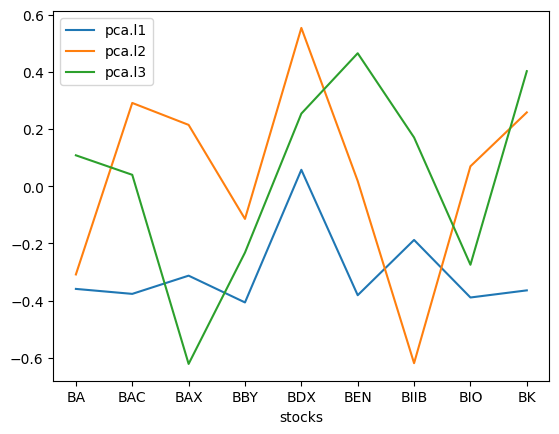

In [12]:
print('PCA loadings: \n',pca_loadings.iloc[:,0:4])
pca_loadings.plot(x='stocks',y=['pca.l1','pca.l2','pca.l3'])

### Создадим нейронную сеть автоэнкодера с входом из нормированных акций, 3 нейронами на внутренним слое и с выходом ,как и размерность входа.

In [13]:
encoding_dim = 3
# encode:
input_layer = Input(shape=(dataNorm.shape[1],))
encoded_layer = Dense(encoding_dim, use_bias=False, activation=None)
encoded = encoded_layer(input_layer)

# decode:
input_encoded = Input((encoding_dim,))
decoded_layer = Dense(dataNorm.shape[1], use_bias=False, activation=None)
decoded = decoded_layer(input_encoded)

# models:
encoder = Model(input_layer, encoded, name="encoder")
decoder = Model(input_encoded, decoded, name="decoder")
autoencoder = Model(input_layer, decoder(encoder(input_layer)), name="autoencoder")

lr = 0.0005
autoencoder.compile(optimizer=Adam(lr), loss='mse')  

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 encoder (Functional)        (None, 3)                 27        
                                                                 
 decoder (Functional)        (None, 9)                 27        
                                                                 
Total params: 54
Trainable params: 54
Non-trainable params: 0
_________________________________________________________________


In [53]:
autoencoder.fit(dataNorm, dataNorm,
                verbose=0,
                epochs=8000,
                batch_size=dataNorm.shape[0])


### Построим коды 3 факторов до вращения

In [54]:
encoded_stocks = pd.DataFrame(encoder.predict(dataNorm), index=dataNorm.index, columns=['ae.f1', 'ae.f2','ae.f3'])
print(encoded_stocks.head())

18/18 [==============================] - 0s 1ms/step
                              ae.f1     ae.f2     ae.f3
Date                                                   
2021-01-04 00:00:00-05:00  0.369671 -2.296996  2.510225
2021-01-05 00:00:00-05:00  0.546138 -2.173537  2.338510
2021-01-06 00:00:00-05:00  0.776591 -1.786726  1.480418
2021-01-07 00:00:00-05:00  0.984896 -1.767218  1.307150
2021-01-08 00:00:00-05:00  0.890952 -1.863351  1.423372


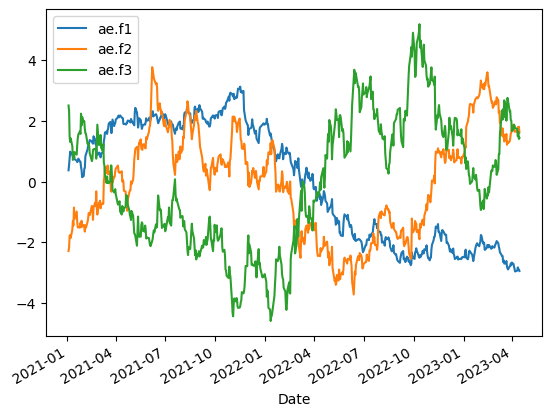

In [55]:
encoded_f1_plot = encoded_stocks['ae.f1']
encoded_f2_plot = encoded_stocks['ae.f2']
encoded_f3_plot = encoded_stocks['ae.f3']
encoded_f1_plot.plot()
encoded_f2_plot.plot()
encoded_f3_plot.plot()
plt.legend()
plt.show()

Полученные графики сильно отличаются от тех, которые получили с помощью метода главных компонент.

### Вычислим соответствующие факторные нагрузки через регрессионную модель

Autoencoder loadings by regression: 
   stocks   rega.l1   rega.l2   rega.l3
0     BA  0.244519  0.485314 -0.246407
1    BAC  0.236661 -0.008083 -0.493682
2    BAX  0.703171 -0.715038 -0.178166
3    BBY  0.520089 -0.010986 -0.258957
4    BDX -0.310541 -0.133057 -0.265180
5    BEN -0.052610  0.659721 -0.525729
6   BIIB  0.096909  0.704366  0.026270
7    BIO  0.516113 -0.195758 -0.306067
8     BK -0.047796  0.413296 -0.590068


<Axes: xlabel='stocks'>

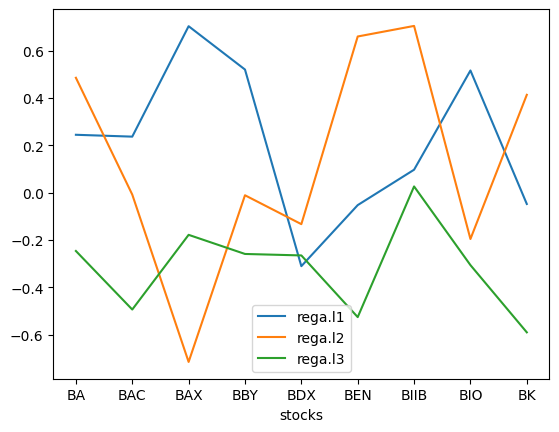

In [56]:
regr = linear_model.LinearRegression()

rfa1 = regr.fit(dataNorm, encoded_stocks['ae.f1'])
rega_l1 =pd.DataFrame({'rega.l1': rfa1.coef_})

rfa2 = regr.fit(dataNorm, encoded_stocks['ae.f2'])
rega_l2 =pd.DataFrame({'rega.l2': rfa2.coef_})

rfa3 = regr.fit(dataNorm, encoded_stocks['ae.f3'])
rega_l3 =pd.DataFrame({'rega.l3': rfa3.coef_})

ae_loadings_by_regression = stocks.join([rega_l1,rega_l2,rega_l3])
print('Autoencoder loadings by regression: \n',ae_loadings_by_regression)
ae_loadings_by_regression.plot(x='stocks',y=['rega.l1','rega.l2','rega.l3'])

### Повернём факторы так, чтобы они стали некоррелированными и сравним графически повернутые факторы с факторами PCA

Посмотрим на матрицу корреляции факторов

In [57]:
encoded_stocks.corr().round(2)

,ae.f1,ae.f2,ae.f3
ae.f1,1.00,0.26,-0.79
ae.f2,0.26,1.00,-0.47
ae.f3,-0.79,-0.47,1.00


Наблюдается сильная корреляция факторов

Повернем факторы и нагрузки автоэнкодера, использую совственные вектора ковариационной матрицы

In [58]:
encoded_stocks.cov()

,ae.f1,ae.f2,ae.f3
ae.f1,3.766891,0.868370,-3.342010
ae.f2,0.868370,2.896889,-1.749281
ae.f3,-3.342010,-1.749281,4.754233


In [59]:
eg_vect_factors = np.linalg.eig(encoded_stocks.cov())[1]
eg_vect_factors = pd.DataFrame(eg_vect_factors)
eg_vect_factors 

,0,1,2
0,-0.599776,-0.672957,-0.432895
1,-0.331849,-0.283090,0.899853
2,0.728111,-0.683366,0.053530


Умножим факторы автоэнкодера на эти собственные вектора. Таким образом произведем поворот факторов автоэнкодера

In [60]:
rotated_factors = pd.DataFrame(np.dot(encoded_stocks, eg_vect_factors), \
                              columns=['rot.f1','rot.f2','rot.f3'], index=dataNorm.index)
rotated_factors.head()

,rot.f1,rot.f2,rot.f3
Date,,,
2021-01-04 00:00:00-05:00,2.368258,-1.313920,-2.092617
2021-01-05 00:00:00-05:00,2.096420,-1.350280,-2.067105
2021-01-06 00:00:00-05:00,1.205051,-1.028476,-1.864728
2021-01-07 00:00:00-05:00,0.947483,-1.055774,-1.946623
2021-01-08 00:00:00-05:00,1.120353,-1.044761,-1.986239


Снова посмотрим на ковариационную матрицу

In [61]:
rotated_factors.cov()

,rot.f1,rot.f2,rot.f3
rot.f1,8.304455e+00,1.314442e-15,-8.928286e-16
rot.f2,1.314442e-15,7.384779e-01,-6.448206e-16
rot.f3,-8.928286e-16,-6.448206e-16,2.375080e+00


Теперь факторы стали некоррелируемыми как и нужно.  
Факторы PCA упорялочены по убыванию дисперсии, но, воможно, повернутые факторы идут в другом порядке. Поэтому мы посмотрим на корреляцию между PCA факторами и факторами автоэнкодера с помощью следующей функции

In [62]:
def defineOrder(pca_factors,rot_factors):
    pca_cols = pca_factors.columns
    rot_cols = rot_factors.columns
    ncol = len(pca_cols)
    mylist = []
    alllist = []
    i = 0

    for pca_col in pca_cols:
        pcaf =pca_factors[pca_col]
        j = 0
        for rot_col in rot_cols:
            rotf = rot_factors[rot_col]
            cor = np.corrcoef(pcaf,rotf)[0,1]
            print(i,j,abs(cor))
            mylist = []
            mylist.append(i)
            mylist.append(j)
            mylist.append(abs(cor))
            mylist.append(np.sign(cor))
            alllist.append(mylist)
            j = j+1
        i = i +1
    df = pd.DataFrame(alllist,columns = ['col1','col2','value','sign'])
    df = df.sort_values(by=['value'], ascending=False)
    df = df[:ncol]
    df = df.sort_values(by='col1')
    return df

In [63]:
    norm_factors = pd.DataFrame()

    for i in range(3):
        rotated_factors['rot.f'+str(i+1)] = rotated_factors['rot.f'+str(i+1)] / rotated_factors['rot.f'+str(i+1)].std()
        norm_factors['pca.f'+str(i+1)] = pca_factors['pca.f'+str(i+1)] / pca_factors['pca.f'+str(i+1)].std()

In [64]:
orderdf = defineOrder(norm_factors, rotated_factors)
orderdf

0 0 0.998567659894607
0 1 0.026703460158807646
0 2 0.046363281033103734
1 0 0.0005576539504858346
1 1 0.8613044911946273
1 2 0.5080888332465017
2 0 0.053500632096071844
2 1 0.5073869319003365
2 2 0.8600559189390204


,col1,col2,value,sign
0,0,0,0.998568,1.0
4,1,1,0.861304,1.0
8,2,2,0.860056,1.0


**Вывод:** получили, что  
1-му PCA фактору соответствует 1-й повернутый от автоэнкодера с тем же знаком,  
2-му PCA фактору соответствует 2-й повернутый от автоэнкодера с тем же знаком,  
3-му PCA фактору соответствует 3-й повернутый от автоэнкодера с тем же знаком.

Посмотрим на графики факторов согласно полученному только что соответствию

Первые факторы

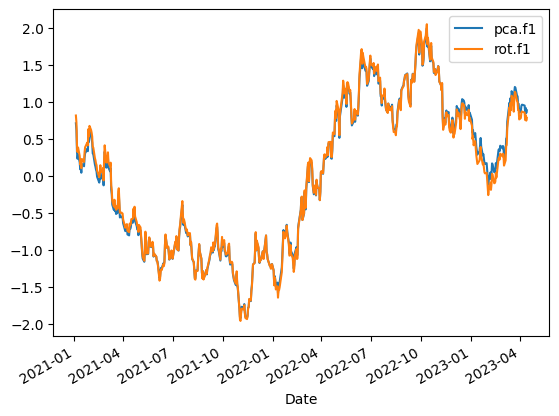

In [65]:
pca_f_plot = pca_factors['pca.f1']/pca_factors['pca.f1'].std()
rot_f_plot = rotated_factors['rot.f1']/rotated_factors['rot.f1'].std()
pca_f_plot.plot()
rot_f_plot.plot()
plt.legend()
plt.show()

Второй факторы

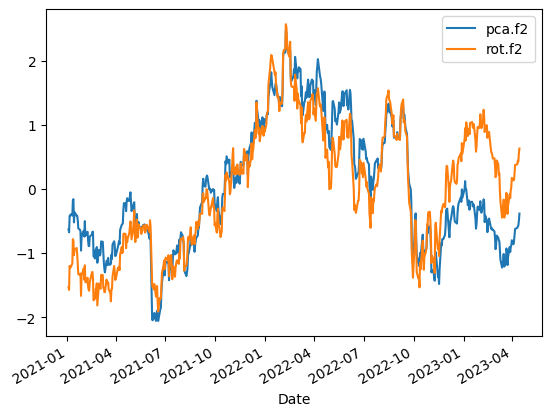

In [66]:
pca_f_plot = pca_factors['pca.f2']/pca_factors['pca.f2'].std()
rot_f_plot = rotated_factors['rot.f2']/rotated_factors['rot.f2'].std()
pca_f_plot.plot()
rot_f_plot.plot()
plt.legend()
plt.show()

Третьи факторы

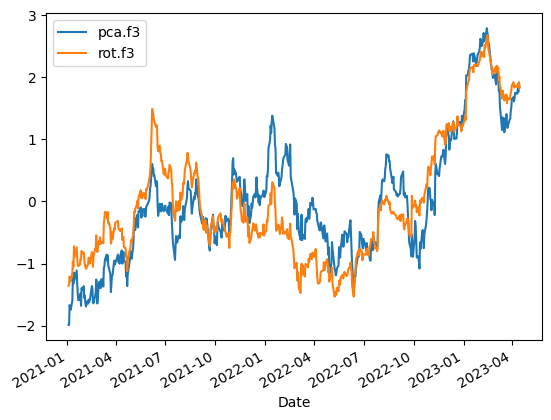

In [67]:
pca_f_plot = pca_factors['pca.f3']/pca_factors['pca.f3'].std()
rot_f_plot = rotated_factors['rot.f3']/rotated_factors['rot.f3'].std()
pca_f_plot.plot()
rot_f_plot.plot()
plt.legend()
plt.show()

**Вывод:** как выидим факторы стали очень похожи, особенно первые.

### Повернём факторные нагрузки и сравните на графиках с нагрузками PCA

Нагрузки автоэнкодера также повернём с помощью уже имеющийся у нас ковариационной матрицы.

  stocks    rot.l1    rot.l2    rot.l3
0     BA -0.487119 -0.133552  0.317670
1    BAC -0.498716  0.180391 -0.136150
2    BAX -0.314184 -0.149031 -0.957366
3    BBY -0.496840 -0.169925 -0.248892
4    BDX  0.037329  0.427862  0.000505
5    BEN -0.570163  0.207909  0.588285
6   BIIB -0.272740 -0.282567  0.593281
7    BIO -0.467440 -0.082749 -0.415960
8     BK -0.538120  0.318398  0.361010


<Axes: xlabel='stocks'>

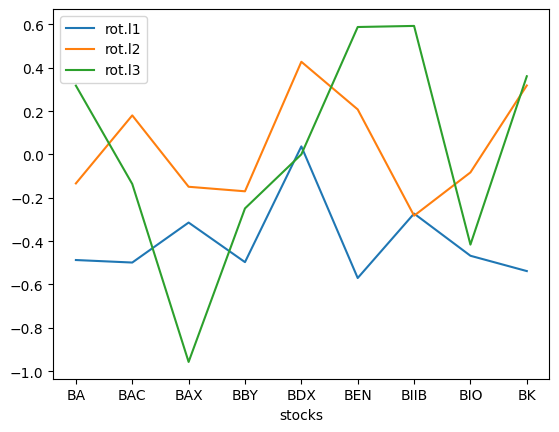

In [78]:
rotated_loadings = pd.DataFrame(np.dot(ae_loadings_by_regression[['rega.l1','rega.l2','rega.l3']], \
                                       eg_vect_factors),columns=['rot.l1','rot.l2','rot.l3'])
rotated_loadings = stocks.join(rotated_loadings)
print(rotated_loadings)
rotated_loadings.plot(x='stocks',y=['rot.l1','rot.l2','rot.l3'])

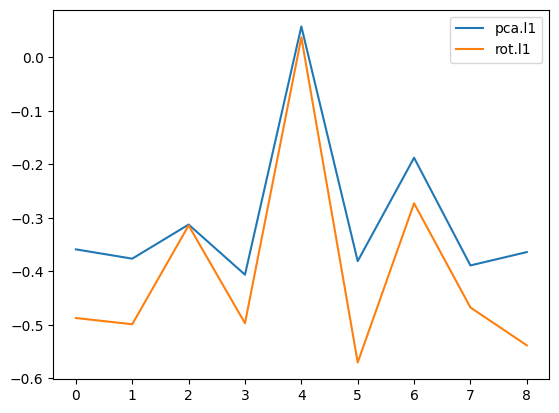

In [72]:
pca_l_plot = pca_loadings['pca.l1']
rot_l_plot = rotated_loadings['rot.l1']
pca_l_plot.plot(x=stocks)
rot_l_plot.plot(x=stocks)
plt.legend()
plt.show()

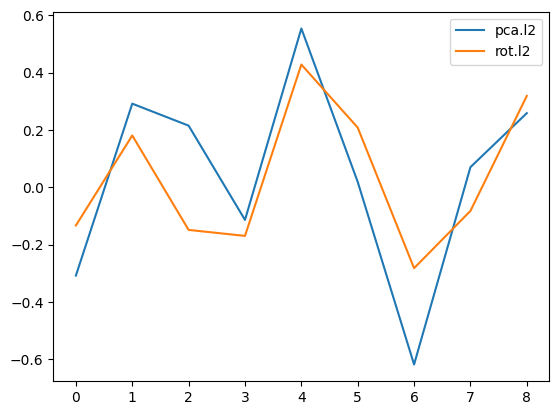

In [73]:
pca_l_plot = pca_loadings['pca.l2']
rot_l_plot = rotated_loadings['rot.l2']
pca_l_plot.plot(x=stocks)
rot_l_plot.plot(x=stocks)
plt.legend()
plt.show()

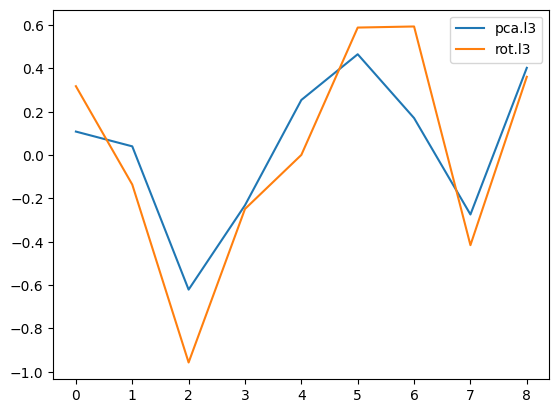

In [75]:
pca_l_plot = pca_loadings['pca.l3']
rot_l_plot = rotated_loadings['rot.l3']
pca_l_plot.plot(x=stocks)
rot_l_plot.plot(x=stocks)
plt.legend()
plt.show()

Как видим из графиков, нагрузки получились похожими.